In [1]:
import sys
sys.path.append('/usr/users/pred_lung_cancer/piquet_con/Project-lung-cancer/Model_1/Segmentation')
sys.path.append('/usr/users/pred_lung_cancer/piquet_con/Project-lung-cancer/Model_1/T_Stage_Classification')
from TheDuneAI import ContourPilot as cp
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import cv2

# Imports for Xplique
import requests
from PIL import Image
import xplique
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad, SquareGrad,
                                  Occlusion, Rise, SobolAttributionMethod, HsicAttributionMethod)
from xplique.plots import plot_attributions
from xplique.metrics import Deletion, MuFidelity, Insertion, AverageStability
from xplique.plots.metrics import barplot

import shap

BATCH_SIZE = 8

import SimpleITK as sitk
import os
import pandas as pd
import re
import openpyxl

2025-06-21 16:30:37.127171: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-21 16:30:37.129744: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-21 16:30:37.178544: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-21 16:30:37.179319: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-21 16:30:38.589460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

# Visualize the data for one patient

In [2]:
model_path = '/usr/users/pred_lung_cancer/piquet_con/Project-lung-cancer/Model_1/Segmentation/model_files'
path_to_test_data = '/mounts/Datasets4/pred_lung_cancer/NIH dataset_raw/NRRD/converted_nrrds/'
save_path = '/mounts/Datasets4/pred_lung_cancer/NIH dataset_raw/Processed'

In [5]:
model = cp(model_path,path_to_test_data,save_path,verbosity=True)
for i, layer in enumerate(model.model1.layers):
        print(i, layer.name, layer.__class__.__name__)
print(model.model1.input_shape)
print(model.model1.output_shape)

100%|██████████| 299/299 [00:00<00:00, 7249.66it/s]

299  Patients found
Epoch end
------- Loading patients in predict mode -------
0 input_1 InputLayer
1 conv2d_1 Conv2D
2 conv2d_2 Conv2D
3 max_pooling2d_1 MaxPooling2D
4 conv2d_3 Conv2D
5 conv2d_4 Conv2D
6 max_pooling2d_2 MaxPooling2D
7 conv2d_5 Conv2D
8 conv2d_6 Conv2D
9 max_pooling2d_3 MaxPooling2D
10 conv2d_7 Conv2D
11 conv2d_8 Conv2D
12 dropout_1 Dropout
13 max_pooling2d_4 MaxPooling2D
14 conv2d_9 Conv2D
15 conv2d_10 Conv2D
16 dropout_2 Dropout
17 up_sampling2d_1 UpSampling2D
18 conv2d_11 Conv2D
19 concatenate_1 Concatenate
20 conv2d_12 Conv2D
21 conv2d_13 Conv2D
22 up_sampling2d_2 UpSampling2D
23 conv2d_14 Conv2D
24 concatenate_2 Concatenate
25 conv2d_15 Conv2D
26 conv2d_16 Conv2D
27 up_sampling2d_3 UpSampling2D
28 conv2d_17 Conv2D
29 concatenate_3 Concatenate
30 conv2d_18 Conv2D
31 conv2d_19 Conv2D
32 up_sampling2d_4 UpSampling2D
33 conv2d_20 Conv2D
34 concatenate_4 Concatenate
35 conv2d_21 Conv2D
36 conv2d_22 Conv2D
37 conv2d_23 Conv2D
38 conv2d_24 Conv2D
(None, 512, 512, 1)
(Non

In [6]:
gen_with_progress = tqdm(model.Patients_gen, desc='Progress')
gen_iterator = iter(gen_with_progress)  
img, _, filename, params = next(gen_iterator)
print(img.shape)
print("filename", filename)

# Select the middle slice of the 3D image
print(f"Image shape: {img.shape}") 
img=img.squeeze()  
print(f"Image shape after squeeze: {img.shape}") 
# --- Select the middle slice ---
middle_index = img.shape[0] // 2
print(f"Middle slice index: {middle_index}")
middle_slice = img[middle_index, :, :]  # shape: (512, 512)

mask = model.model1.predict(img, batch_size=1, verbose=1)


Progress:   0%|          | 0/299 [00:00<?, ?it/s]

(46, 512, 512)
Window limits  -1000 150.0
Amount of unique values, original img:  1151 resampled img:  46
(1, 36, 512, 512)
filename ['/mounts/Datasets4/pred_lung_cancer/NIH dataset_raw/NRRD/converted_nrrds/Lung_Dx-A0155/image.nrrd']
Image shape: (1, 36, 512, 512)
Image shape after squeeze: (36, 512, 512)
Middle slice index: 18
36/36 [==============================] - 16s 444ms/step


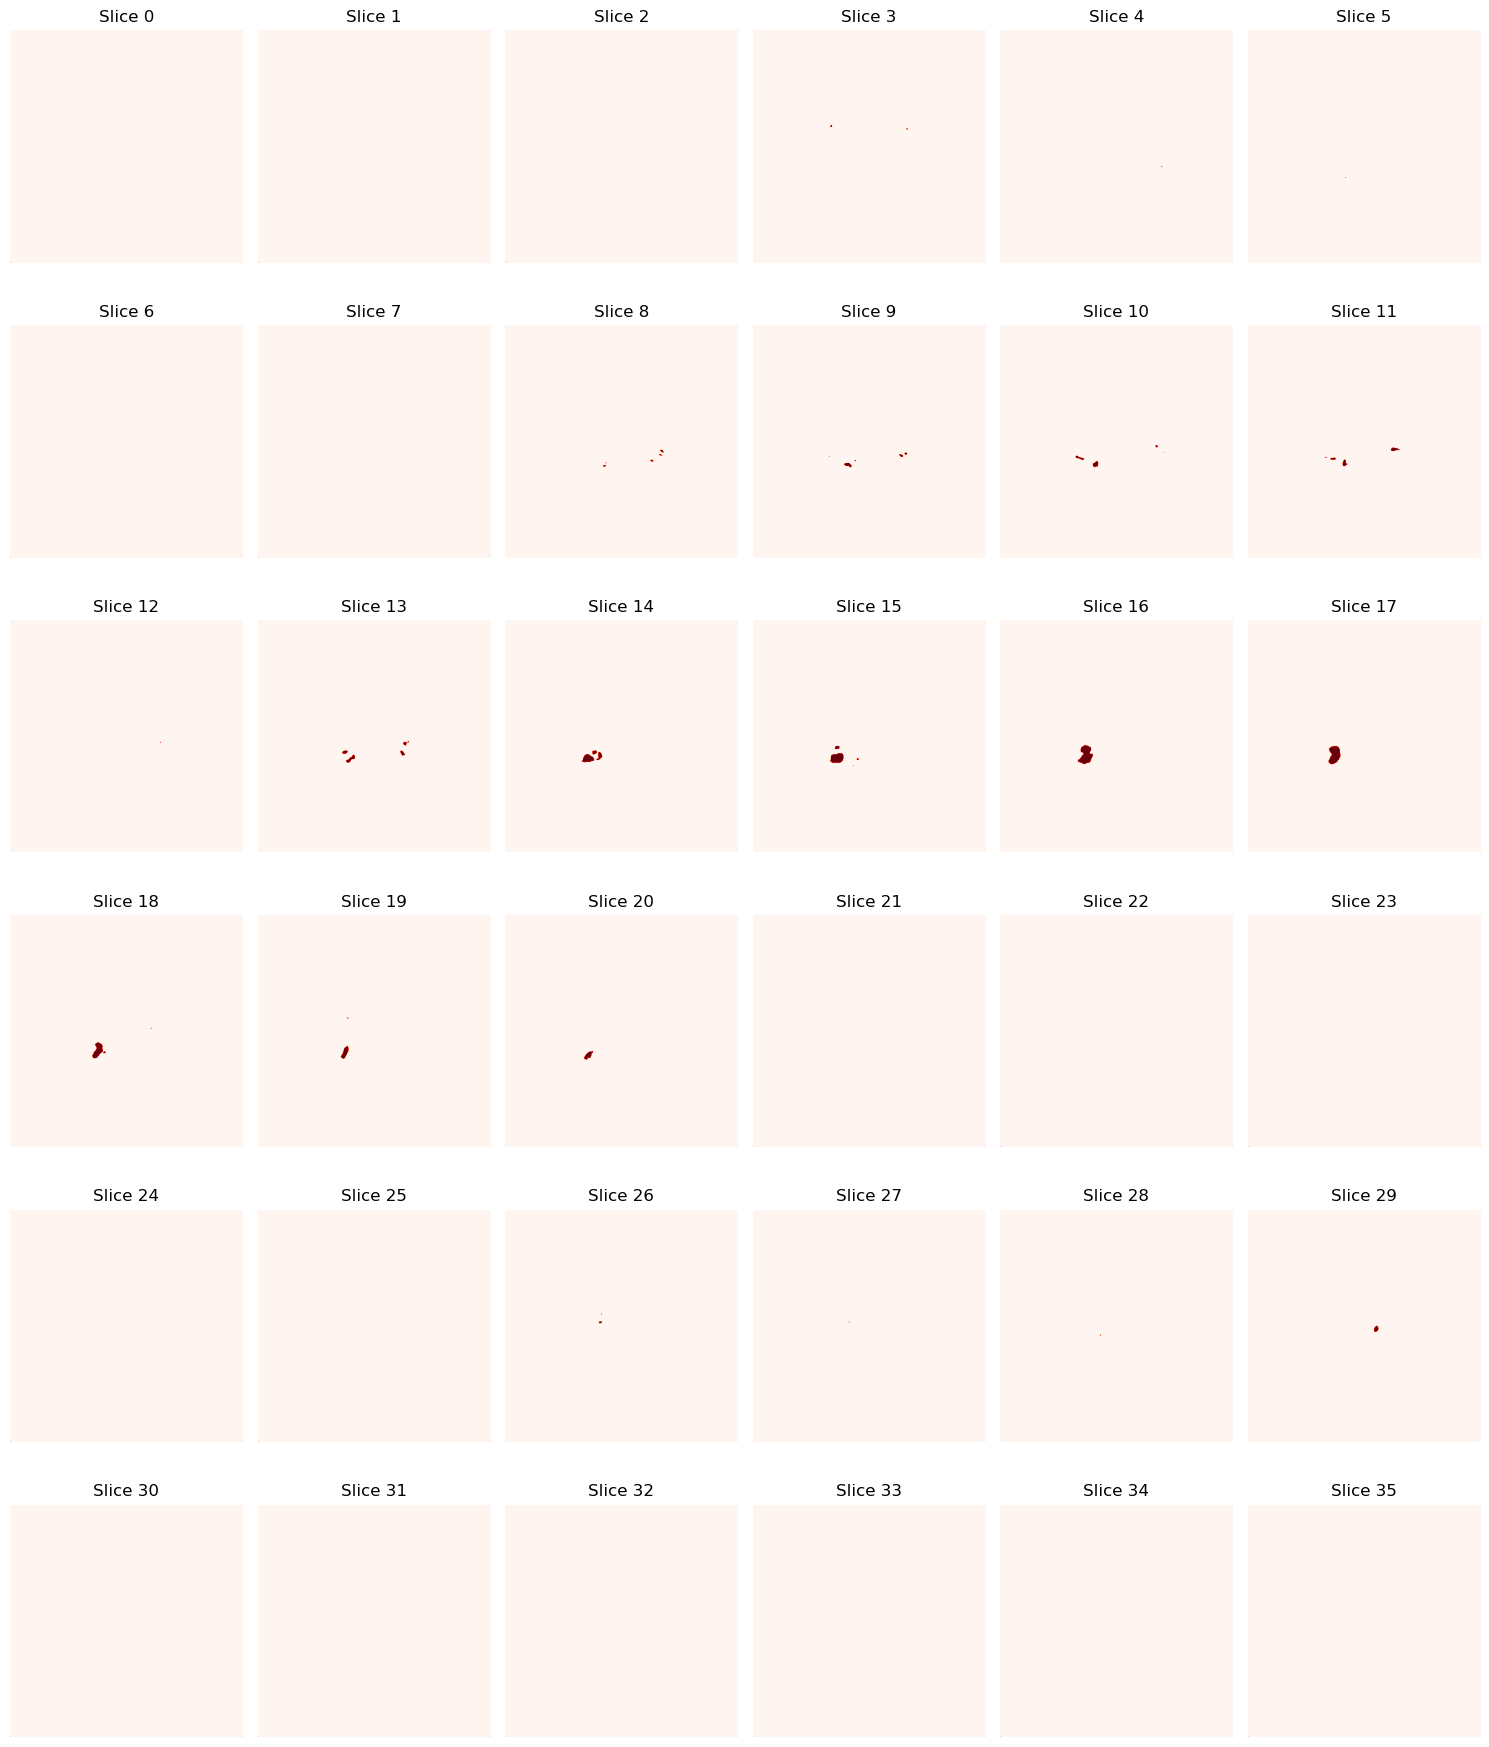

In [ ]:
num_slices = img.shape[0]
cols = 6
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
axes = axes.flatten() if rows > 1 else [axes] if cols == 1 else axes

for i in range(num_slices):
    axes[i].imshow(img[i], cmap='gray')
    axes[i].imshow(mask[i], cmap='Reds', alpha=0.5)  # Overlay the mask with some transparency
    axes[i].set_title(f'Slice {i}')
    axes[i].axis('off')

# Hide unused subplots
for i in range(num_slices, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Grad-cam (basic version)

In [6]:
def compute_gradcam(model, image, target_layer_name):
    grad_model = tf.keras.models.Model(
        [model.input],
        [model.get_layer(target_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        # Use mean prediction over the output map for loss
        loss = tf.reduce_mean(predictions)

    grads = tape.gradient(loss, conv_outputs)[0]
    conv_outputs = conv_outputs[0]

    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]

    cam = np.maximum(cam, 0)
    cam = cam / (np.max(cam) + 1e-8)
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    
    return cam

def show_gradcam_overlay(image, cam, alpha=0.4):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    # Convert grayscale to BGR (3 channels)
    if len(image.shape) == 2:
        image_color = cv2.cvtColor(np.uint8(image * 255), cv2.COLOR_GRAY2BGR)
    else:
        image_color = np.uint8(image * 255)
    overlay = cv2.addWeighted(image_color, 1-alpha, heatmap, alpha, 0)
    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM Overlay")
    plt.show()


Middle slice shape: (512, 512)


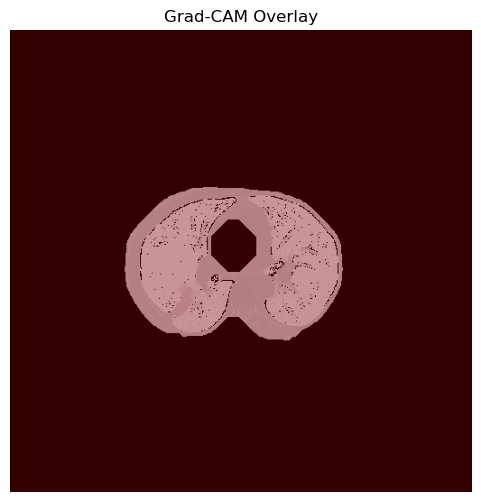

: 

In [ ]:
print(f"Middle slice shape: {middle_slice.shape}")
# --- Prepare the slice for the model ---
input_slice = middle_slice.reshape(512, 512, 1).astype(np.float32)

# --- Compute Grad-CAM ---
cam = compute_gradcam(model.model1, input_slice, target_layer_name="conv2d_23")

# --- Visualize overlay ---
show_gradcam_overlay(input_slice.squeeze(), cam)

# Xplique - local explanability

In [ ]:
img_tf = tf.convert_to_tensor(img, dtype=tf.float32)
img_tf = tf.expand_dims(img_tf, axis=-1)  # Now shape is [38, 512, 512, 1]
mask_tf = tf.convert_to_tensor(mask, dtype=tf.float32)
mask_alpha = 0.5
images_with_masks = (1 - mask_alpha) * img_tf + mask_alpha * mask_tf

explainers = {
    #Saliency: {},
    GradientInput: {},
    #IntegratedGradients: {"steps": 20},
    #SmoothGrad: {"nb_samples": 50, "noise": 0.75},
    #VarGrad: {"nb_samples": 50, "noise": 0.75},
    #SquareGrad: {"nb_samples": 100, "noise": 0.5},
    #Occlusion: {"patch_size": 40, "patch_stride": 10, "occlusion_value": 0}, -> to long to run
    #Rise: {"nb_samples": 4000, "grid_size": 13}, -> to long to run
    #SobolAttributionMethod: {"nb_design": 32, "grid_size": 13},
    #HsicAttributionMethod: {"nb_design": 1500, "grid_size": 13}
}

explanations = {}
for explainer_class, params in explainers.items():
    print(explainer_class.__name__)

    # instanciate explainer
    explainer = explainer_class(model.model1, operator=xplique.Tasks.SEMANTIC_SEGMENTATION,
                                batch_size=1, **params)

    print("img shape:", img_tf.shape)
    print("mask shape:", mask_tf.shape)
    # compute explanations
    explanation = explainer(img_tf, mask_tf)

    # show explanations for a method
    plot_attributions(explanation, images_with_masks,
                      img_size=4., cols=img_tf.shape[0],
                      cmap='jet', alpha=0.3, absolute_value=False, clip_percentile=0.5)
    plt.show()

    # keep explanations in memory for metrics
    explanations[explainer_class.__name__] = explanation

HsicAttributionMethod
img shape: (36, 512, 512, 1)
mask shape: (36, 512, 512, 1)
